In [1]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import BatchNormalization , GRU
# from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 
print ("Done")

2024-04-24 15:08:44.854133: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 15:08:44.854455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 15:08:45.103533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Done


In [2]:
#preparing data set

ravdess = "/kaggle/input/ravdess-emotional-speech-audio"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)
Crema = "/kaggle/input/cremad/AudioWAV/" # audios with different emotions
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'audio_speech_actors_01-24', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


In [3]:
import os


ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

file_emotion = []
file_path = []

# Filter out directories that don't correspond to actor directories
actor_directories = [d for d in ravdess_directory_list if d.startswith('Actor_')]

for directory in actor_directories:
    actor_directory = os.path.join(ravdess, directory)  # Get the full path to the actor directory
    files = os.listdir(actor_directory)  # List all files for this actor
    for file in files:
        part = file.split('.')[0].split('-')
        # Ensure that the file name format is correct and contains at least three parts
        if len(part) >= 3:
            # Third part in each file represents the emotion associated with that file
            file_emotion.append(int(part[2]))
            file_path.append(os.path.join(actor_directory, file))  # Full path to the file
        else:
            print(f"Issue with filename: {file}")

# Now you have file_emotion and file_path populated with emotions and file paths respectively.


['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'audio_speech_actors_01-24', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


In [4]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())

   Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/A...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/A...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/A...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/A...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/A...
______________________________________________
     Emotions                                               Path
1435     fear  /kaggle/input/ravdess-emotional-speech-audio/A...
1436    angry  /kaggle/input/ravdess-emotional-speech-audio/A...
1437      sad  /kaggle/input/ravdess-emotional-speech-audio/A...
1438  disgust  /kaggle/input/ravdess-emotional-speech-audio/A...
1439    angry  /kaggle/input/ravdess-emotional-speech-audio/A...
_______________________________________________
Emotions
neutral     288
surprise    192
disgust     192
fear        192
sad         192
happy       192
angry       192
Name: count, dty

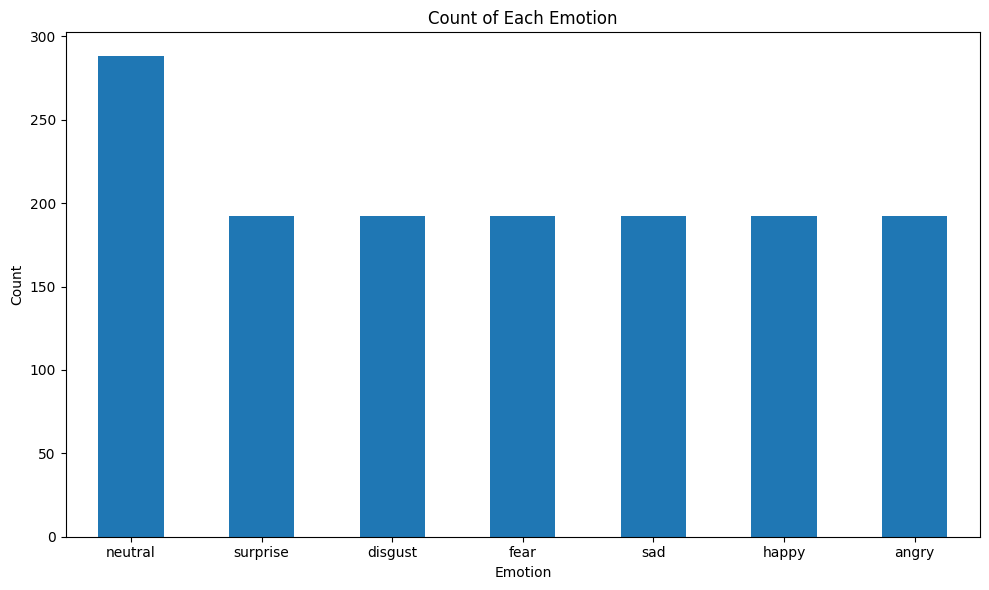

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataset is in a CSV file named 'emotions_dataset.csv'
data = ravdess_df

# Assuming the column containing emotions is named 'emotion'
emotion_counts = data['Emotions'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar')
plt.title('Count of Each Emotion')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [5]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())

Emotions
disgust    1271
happy      1271
sad        1271
fear       1271
angry      1271
neutral    1087
Name: count, dtype: int64


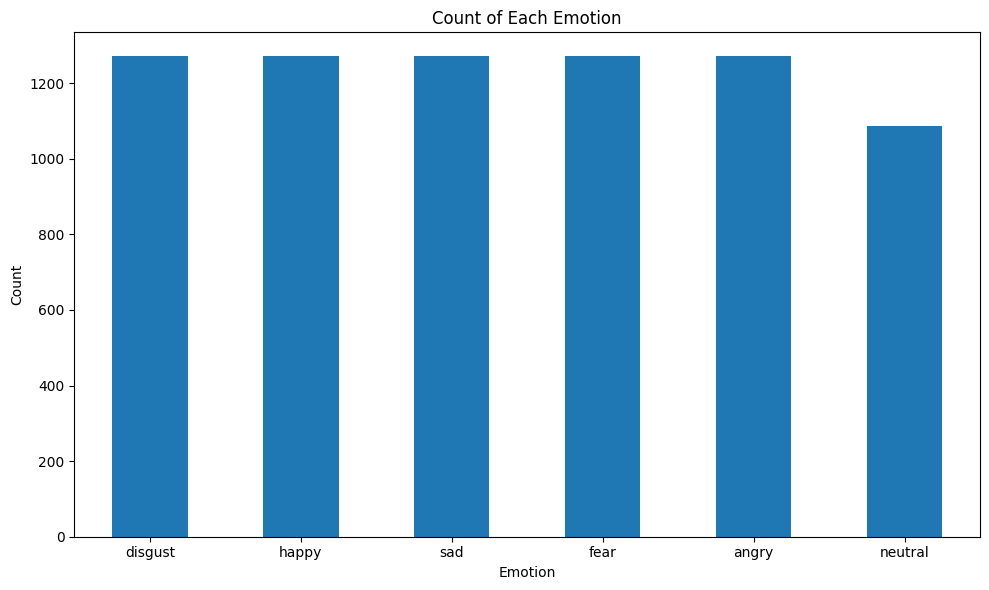

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataset is in a CSV file named 'emotions_dataset.csv'
data = Crema_df

# Assuming the column containing emotions is named 'emotion'
emotion_counts = data['Emotions'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar')
plt.title('Count of Each Emotion')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [6]:
import os
import pandas as pd


tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for directory in tess_directory_list:
    directory_path = os.path.join(Tess, directory)
    files = os.listdir(directory_path)
    for file in files:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part == 'ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(os.path.join(directory_path, file))
        
# DataFrame for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# DataFrame for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

Tess_df = pd.concat([emotion_df, path_df], axis=1)
print(Tess_df['Emotions'].value_counts())


Emotions
fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: count, dtype: int64


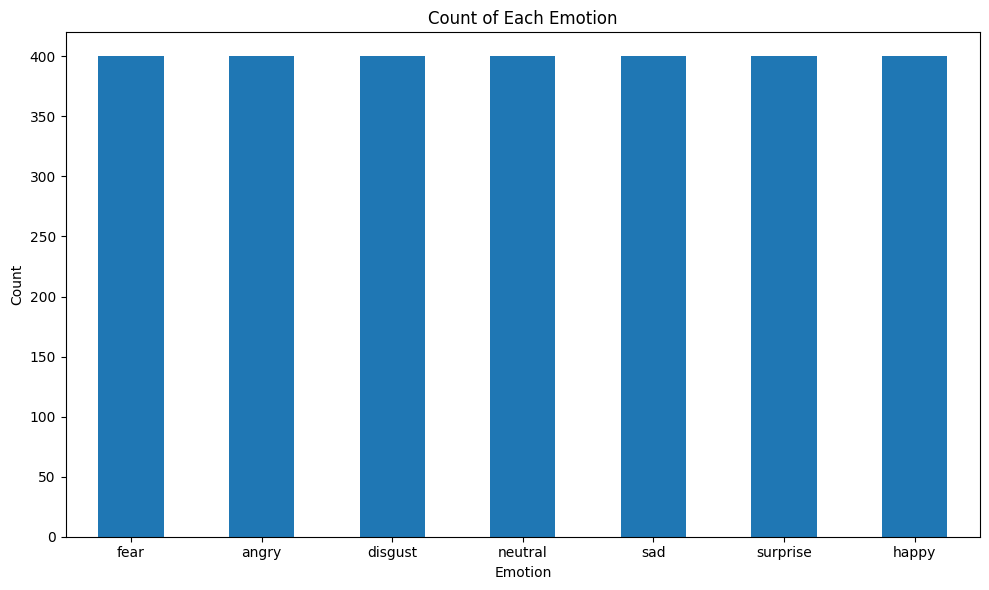

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataset is in a CSV file named 'emotions_dataset.csv'
data = Tess_df

# Assuming the column containing emotions is named 'emotion'
emotion_counts = data['Emotions'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar')
plt.title('Count of Each Emotion')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [7]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())

Emotions
neutral     120
happy        60
fear         60
disgust      60
angry        60
surprise     60
sad          60
Name: count, dtype: int64


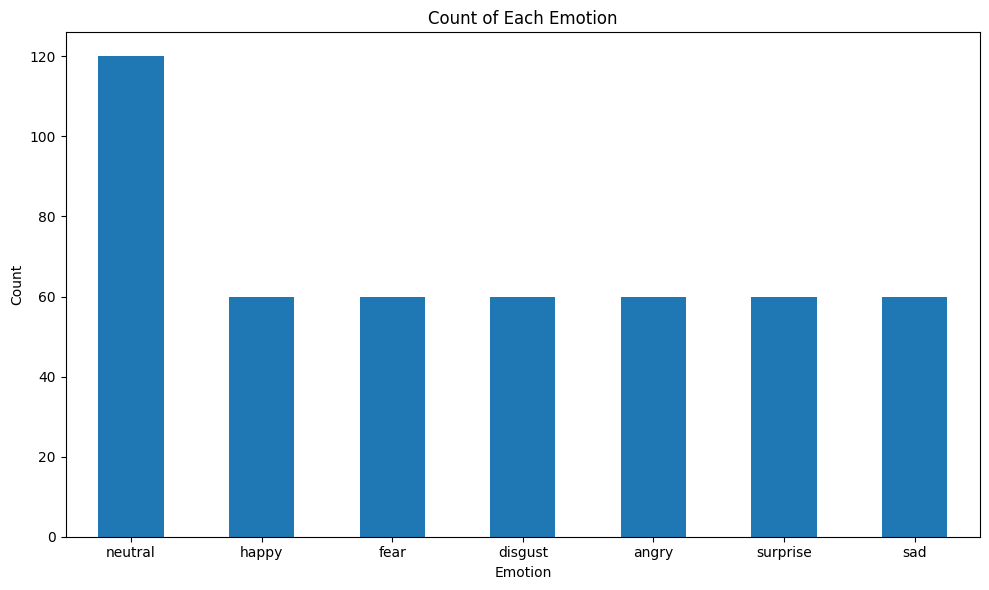

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataset is in a CSV file named 'emotions_dataset.csv'
data = Savee_df

# Assuming the column containing emotions is named 'emotion'
emotion_counts = data['Emotions'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar')
plt.title('Count of Each Emotion')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [13]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)

data_path.to_csv("Classified_All.csv",index=False)
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/A...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/A...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/A...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/A...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/A...


Feature Extract

In [14]:
import librosa
import numpy as np
import csv
import time
import pywt  # Adding import statement for pywt

def extract_features(audio_file):
    start_time = time.time()
    # Load audio file
    y, sr = librosa.load(audio_file)
    
    # Time-domain features
    mean = np.mean(y)
    variance = np.var(y)
    skewness = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    kurtosis = np.mean(librosa.feature.spectral_flatness(y=y))
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
    rms_energy = np.mean(librosa.feature.rms(y=y))
    
    # Intensity (average energy)
    intensity = np.mean(np.abs(y))
    
    # Pitch (fundamental frequency)
    pitch = librosa.piptrack(y=y, sr=sr)[0]
    pitch_freqs = [max(pitch[:, i]) for i in range(pitch.shape[1]) if max(pitch[:, i]) > 0]
    if pitch_freqs:
        pitch = np.mean(pitch_freqs)
    else:
        pitch = 0
    
    # Frequency-domain features
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0].mean()
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0].mean()
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr).mean(axis=1)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0].mean()
    
    # Mel-frequency cepstral coefficients (MFCCs)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    
    # Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_features = {f"chroma{i}": np.mean(chroma[i-1]) for i in range(1, chroma.shape[0] + 1)}
    
    # Spectral features
    spectral_flux = librosa.onset.onset_strength(y=y, sr=sr)
    spectral_flatness = librosa.feature.spectral_flatness(y=y)
    spectral_density = np.sum(librosa.stft(y), axis=1)  # Summing up magnitudes across frequency bins
    
    # Extract each spectral flux coefficient separately
    spectralflux_features = {}
    for i, flux_value in enumerate(spectral_flux):
        spectralflux_features[f"spectralflux{i+1}"] = np.mean(flux_value)
    
    # Extract each spectral density coefficient separately
    spectraldes_features = {}
    for i, density_value in enumerate(spectral_density):
        spectraldes_features[f"spectraldes{i+1}"] = np.mean(density_value)
    
    # Extract each spectral flatness coefficient separately
    spectralflatness_features = {}
    for i, flatness_value in enumerate(spectral_flatness):
        for j, value in enumerate(flatness_value):
            spectralflatness_features[f"spectralflatness{j+1}_{i+1}"] = value
    
    # Wavelet transform (example code, may need customization)
    coeffs, _ = pywt.dwt(y, 'db1')  # Example of using wavelet transform (you might need to adjust parameters)
    
    # Extract each wavelet coefficient separately
    waveletcoeffs_features = {}
    for i, coeff_value in enumerate(coeffs):
        waveletcoeffs_features[f"waveletcoeff{i+1}"] = np.mean(coeff_value)
    
    end_time = time.time()
    time_taken = end_time - start_time
    
    # Extract each MFCC coefficient separately
    mfcc_features = {}
    for i in range(1, 14):
        mfcc_features[f"mfcc{i}"] = np.mean(mfccs[i-1])
    
    return {
        "mean": mean,
        "variance": variance,
        "skewness": skewness,
        "kurtosis": kurtosis,
        "zero_crossing_rate": zero_crossing_rate,
        "rms_energy": rms_energy,
        "intensity": intensity,
        "pitch": pitch,
        "spectral_centroid": spectral_centroid,
        "spectral_bandwidth": spectral_bandwidth,
        **{f"spectralcontrast{i+1}": spectral_contrast[i] for i in range(len(spectral_contrast))},  # Unpack Spectral contrast features
        "spectral_rolloff": spectral_rolloff,
        **mfcc_features,  # Unpack MFCC coefficients
        **chroma_features,  # Unpack Chroma features
        **spectralflux_features,  # Unpack Spectral flux features
        **spectraldes_features,  # Unpack Spectral density features
        **spectralflatness_features,  # Unpack Spectral flatness features
        "time_taken": time_taken
    }
# Read audio file paths and their corresponding emotion labels from CSV
def read_audio_paths(csv_file):
    audio_paths = []
    with open(csv_file, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            audio_paths.append((row['Path'], row['Emotions']))  # Assuming 'Path' and 'Emotion' are the column names
    return audio_paths

# Example usage:
csv_file = "/kaggle/working/Classified_All.csv"
audio_paths = read_audio_paths(csv_file)

# List to store features of all audio files
all_features = []

# Start time for the entire dataset
total_start_time = time.time()

# Extract features for each audio file
for audio_path, emotion_label in audio_paths:
    features = extract_features(audio_path)
    features["Path"] = audio_path
    features["Emotions"] = emotion_label
    all_features.append(features)

# End time for the entire dataset
total_end_time = time.time()

# Total time taken for the entire dataset
total_time_taken = total_end_time - total_start_time

# Collect all feature names
all_feature_names = set()
for features in all_features:
    all_feature_names.update(features.keys())

# Create fieldnames list
fieldnames = list(all_feature_names)

# Write features to CSV file
output_csv_file = "AllDatasetFeatures.csv"
with open(output_csv_file, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(all_features)

print("Features extracted and stored in:", output_csv_file)
print("Total time taken for the entire dataset:", total_time_taken, "seconds")

Features extracted and stored in: AllDatasetFeatures.csv
Total time taken for the entire dataset: 9668.672337293625 seconds


In [15]:
import pandas as pd

# Specify the path to your CSV file
csv_file_path = "/kaggle/working/AllDatasetFeatures.csv"
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

df.head()

,spectraldes317,mfcc5,spectraldes309,spectraldes113,spectralflatness147_1,spectraldes331,spectraldes561,spectralflux88,spectralflux93,spectraldes949,...,spectraldes771,spectraldes905,spectraldes569,spectraldes171,spectraldes355,spectralflux132,spectraldes61,spectraldes186,spectraldes775,spectraldes754
0,(1.8737653-4.3169374j),-7.268931,(-1.5215158-0.12593459j),(13.005105+15.074799j),0.145440,(8.04703e-05-6.248751e-05j),(-0.12697636-1.2943223j),0.224487,2.582336,(-0.73775995+0.086518474j),...,(-6.11898e-05-4.13298e-05j),(0.35764584-1.070965j),(0.115207724+0.58914435j),(-5.001547e-05+0.0001218283j),(0.000104455365+4.8822665e-05j),0.251423,(0.47847977-9.155248j),(-2.1302717-0.40184197j),(-7.518654e-05+0.0001042731j),(0.14625987+0.10480795j)
1,(0.058191087-2.8433652j),-4.387534,(-0.39277714-0.09668124j),(2.885488-3.6876254j),0.230050,(-2.4791509e-05+2.7331593e-05j),(0.02240662-0.8298143j),0.848846,1.787441,(0.05258028+0.038390797j),...,(8.185724e-05-0.0001335644j),(-0.11239673+0.0735871j),(-0.0062445016-0.090880066j),(-1.4331177e-05-9.675973e-05j),(6.256817e-05+3.00803e-05j),0.437164,(-3.3653145+3.0234356j),(0.04027428-1.3233194j),(1.3102996e-05-0.00010625401j),(0.07196729-0.116191246j)
2,(2.2310874+0.81511515j),-11.664724,(-0.123640984-1.8243663j),(-17.336527-5.7332354j),0.088197,(-3.7482314e-05-3.634319e-05j),(-0.5039215-0.20875542j),2.395227,3.221014,(0.06578081-0.36782274j),...,(6.6910834e-06-5.912313e-05j),(-0.056653734+0.004947699j),(-0.053672418+1.1475786j),(-6.9309735e-06+3.24621e-05j),(-5.703748e-05-0.00010287996j),0.708161,(3.1826153+2.1453424j),(-1.6285356+1.2305005j),(4.3032094e-05+7.73619e-06j),(0.18104824+0.3865631j)
3,(-0.63125694+0.10929234j),-9.703859,(0.6076294+0.17742923j),(0.77443993-2.757843j),0.164663,(-0.00031438097-6.137787e-05j),(-0.4872504-0.25740743j),6.452097,0.223801,(-0.03369533-0.06712881j),...,(4.6234636e-05+9.694399e-06j),(0.0011072374-0.0035644595j),(0.106677115-0.1872206j),(-0.00013077183-0.00016389211j),(0.00011410842-0.00028855086j),0.032028,(1.1135925+1.4531207j),(0.19789225-0.9240871j),(-3.9230028e-05-0.00014710438j),(0.15357363-0.05277221j)
4,(-0.6647374+1.003669j),-4.809168,(0.61584586-1.3590076j),(-10.148581-4.077933j),0.093712,(8.675459e-06-7.1180795e-05j),(0.49466032-1.6875914j),3.260123,2.690622,(-0.41517982-0.24549979j),...,(-5.8498335e-06-1.7281127e-05j),(0.005782011-0.23816116j),(-0.53349936+0.41840762j),(4.4078603e-05-2.9162547e-06j),(-2.7229908e-07-6.871944e-05j),0.458317,(8.595419-5.7145405j),(1.3039542+0.40180483j),(-2.3896842e-05-4.4738004e-05j),(-0.096959166-0.1745386j)


In [ ]:
import pandas as pd

# Read the CSV file
input_file = "/kaggle/working/tessfeatures.csv"
output_file = "tess_features.csv"

data = pd.read_csv(input_file)

# Define the character you want to remove
character_to_remove = "("

# Remove the specified character from the DataFrame
data = data.applymap(lambda x: x.replace(character_to_remove, '') if isinstance(x, str) else x)

# Write the modified DataFrame back to a new CSV file
data.to_csv(output_file, index=False)

print("Character '{}' removed from the CSV file.".format(character_to_remove))


In [25]:
import pandas as pd

# Read CSV file
df = pd.read_csv('/kaggle/input/all-dataset/output_file_all.csv')

# Drop a specific column
column_to_drop = 'Path'
df.drop(column_to_drop, axis=1, inplace=True)


# You can also save the modified DataFrame back to a CSV file if needed
df.to_csv('ExtractedFeaturesForAllDataset.csv', index=False)


In [27]:
import pandas as pd

# Read the first CSV file
csv1 = pd.read_csv("/kaggle/working/Classified_All.csv")

# Read the second CSV file
csv2 = pd.read_csv("/kaggle/working/ExtractedFeaturesForAllDataset.csv")

# Copy the 'Emotions' column from csv1 to csv2
csv2['Emotions'] = csv1['Emotions']

# Save the modified csv2 to a new CSV file
csv2.to_csv("/kaggle/working/ExtractedFeaturesForAllDatasetLibrosa.csv", index=False)

print("Emotions column copied from csv1 to csv2 and saved to output.csv")


Emotions column copied from csv1 to csv2 and saved to output.csv


In [28]:
import pandas as pd

# Read CSV file
df = pd.read_csv('/kaggle/working/ExtractedFeaturesForAllDatasetLibrosa.csv')

# Convert string values to float for all columns
for column in df.columns:
    # Check if the column contains string values
    if df[column].dtype == 'object':
        # Use try-except to handle potential conversion errors
        try:
            df[column] = df[column].str.replace(',', '').astype(float)
            # If your string values contain commas as thousands separators, remove them with .str.replace(',', '')
        except ValueError:
            print(f"Unable to convert values in column '{column}' to float.")

# Now, string values that could be converted to float have been converted.
# If any value couldn't be converted, it remains as is.

# You can also save the modified DataFrame back to a CSV file if needed
# df.to_csv('output_file.csv', index=False)


Unable to convert values in column 'Emotions' to float.


In [29]:
import pandas as pd

# Read CSV file
data = pd.read_csv('/kaggle/working/ExtractedFeaturesForAllDatasetLibrosa.csv')

# Check unique values in the 'Emotions' column
unique_emotions = data['Emotions'].unique()

# Print unique values
print("Unique values in the 'Emotions' column:")
print(unique_emotions)


Unique values in the 'Emotions' column:
['surprise' 'neutral' 'disgust' 'fear' 'sad' 'happy' 'angry']


In [30]:
import pandas as pd

# Read the CSV file into a pandas DataFrame
data = pd.read_csv('/kaggle/working/ExtractedFeaturesForAllDatasetLibrosa.csv')

# Fill NaN values with 0
data.fillna(0, inplace=True)

# Now, save the DataFrame back to a CSV file if needed
data.to_csv('/kaggle/working/ExtractedFeaturesForAllDatasetLibrosaCleanedNa.csvv', index=False)


Default Parameters, Standard Scaler

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import time

# Load data from CSV
data = pd.read_csv('/kaggle/input/librosaextractedall/ExtractedFeaturesForAllDatasetLibrosaCleanedNa.csvv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN input
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Feedforward Neural Network': Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Convolutional Neural Network': Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]),
    'Deep Belief Network': Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression()),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Training and evaluating each model
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_cnn, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    else:
        model.fit(X_train, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_scaled)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


2024-04-25 03:41:33.832697: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 03:41:33.832834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 03:41:33.978094: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-pac

Logistic Regression: Accuracy = 0.3321, Precision = 0.3193, Recall = 0.3321, F1 Score = 0.3087, Training Time = 5.4351 s, Prediction Time = 0.0890 s
Naive Bayes: Accuracy = 0.2630, Precision = 0.2754, Recall = 0.2630, F1 Score = 0.2227, Training Time = 0.2479 s, Prediction Time = 0.1482 s
Decision Tree: Accuracy = 0.4205, Precision = 0.4210, Recall = 0.4205, F1 Score = 0.4206, Training Time = 19.0346 s, Prediction Time = 0.0303 s
Random Forest: Accuracy = 0.5372, Precision = 0.5431, Recall = 0.5372, F1 Score = 0.5283, Training Time = 34.4589 s, Prediction Time = 0.1219 s
KNN: Accuracy = 0.3157, Precision = 0.3213, Recall = 0.3157, F1 Score = 0.3066, Training Time = 0.1129 s, Prediction Time = 1.2215 s
Gradient Boosting: Accuracy = 0.5503, Precision = 0.5492, Recall = 0.5503, F1 Score = 0.5458, Training Time = 3066.9965 s, Prediction Time = 0.1183 s
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Feedforward Neural Network: Accuracy = 0.4743, Precision = 0.4746, Recall = 0.4743, F1 Score = 0.473

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier: Accuracy = 0.5277, Precision = 0.5365, Recall = 0.5277, F1 Score = 0.5184, Training Time = 3126.1378 s, Prediction Time = 1.6962 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Default model parameters, MinMax Scaler

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import xgboost as xgb
import lightgbm as lgb
import time

# Load data from CSV
data = pd.read_csv('/kaggle/input/librosaextractedall/ExtractedFeaturesForAllDatasetLibrosaCleanedNa.csvv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN input
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier(),  # Add XGBoost model
    'LightGBM': lgb.LGBMClassifier()  # Add LightGBM model
    # Rest of the models remain the same
}

# Initialize base models
base_models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

# Initialize ensemble methods
ensemble_methods = {
    'Voting Classifier': VotingClassifier(estimators=base_models),
    'Stacking Classifier': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(max_iter=1000)),
    'Bagging Classifier': BaggingClassifier(base_estimator=DecisionTreeClassifier())
}

# Include ensemble methods in the models dictionary
models.update(ensemble_methods)

# Training and evaluating each model
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_cnn, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    else:
        model.fit(X_train, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_scaled)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


Default Model Parameters, Robust Scaler

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import xgboost as xgb
import lightgbm as lgb
import time

# Load data from CSV
data = pd.read_csv('/kaggle/input/librosaextractedall/ExtractedFeaturesForAllDatasetLibrosaCleanedNa.csvv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Emotions'])
y = data['Emotions']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train_encoded, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN input
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

#solver{‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}
# Initializing models
models = {
    'Logistic Regression0': LogisticRegression(max_iter=1000, penalty="l2"),
    'Logistic Regression1': LogisticRegression(max_iter=1000, penalty="none"),
    'Logistic Regression2': LogisticRegression(max_iter=1000, solver="liblinear", penalty="l1"),
    'Logistic Regression3': LogisticRegression(max_iter=1000, solver="liblinear", penalty="l2"),
    'Logistic Regression4': LogisticRegression(max_iter=1000, solver="newton-cg", penalty="l2"),
    'Logistic Regression5': LogisticRegression(max_iter=1000, solver="newton-cg", penalty="none"),
    'Logistic Regression6': LogisticRegression(max_iter=1000, solver="newton-cholesky", penalty="l2"),
    'Logistic Regression7': LogisticRegression(max_iter=1000, solver="newton-cholesky", penalty="none"),
    'Logistic Regression8': LogisticRegression(max_iter=1000, solver="sag", penalty="l2"),
    'Logistic Regression9': LogisticRegression(max_iter=1000, solver="sag", penalty="none"),
    'Logistic Regression10': LogisticRegression(max_iter=1000, solver="saga", penalty="l2"),
    'Logistic Regression11': LogisticRegression(max_iter=1000, solver="saga", penalty="elasticnet", l1_ratio=0.5),
    'Logistic Regression12': LogisticRegression(max_iter=1000, solver="saga", penalty="l1"),
    'Logistic Regression13': LogisticRegression(max_iter=1000, solver="saga", penalty="none"),
    'Logistic Regression14': LogisticRegression(max_iter=1000, class_weight="balanced"),
    'Logistic Regression15': LogisticRegression(max_iter=1000, C=10),
    'Logistic Regression16': LogisticRegression(max_iter=1000, C=0.001),
    'Logistic Regression17': LogisticRegression(max_iter=1000, C=0.1),
}



# Training and evaluating each model
for name, model in models.items():
    start_time = time.time()
    
    if name == 'Feedforward Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Convolutional Neural Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_cnn, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    elif name == 'Deep Belief Network':
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    else:
        model.fit(X_train, y_train_encoded)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    if name in ['Feedforward Neural Network', 'Convolutional Neural Network', 'Deep Belief Network']:
        y_pred_proba = model.predict(X_test_scaled)
        y_pred = y_pred_proba.argmax(axis=-1)
    else:
        y_pred = model.predict(X_test)
    
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Training Time = {train_time:.4f} s, Prediction Time = {predict_time:.4f} s')


2024-04-25 19:19:58.204971: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 19:19:58.205144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 19:19:58.377465: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for a

Logistic Regression0: Accuracy = 0.4435, Precision = 0.4386, Recall = 0.4435, F1 Score = 0.4380, Training Time = 101.0358 s, Prediction Time = 0.1464 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression1: Accuracy = 0.4377, Precision = 0.4330, Recall = 0.4377, F1 Score = 0.4327, Training Time = 100.1232 s, Prediction Time = 0.1543 s
Logistic Regression2: Accuracy = 0.5018, Precision = 0.4996, Recall = 0.5018, F1 Score = 0.4982, Training Time = 1097.4113 s, Prediction Time = 0.0591 s
